In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

In [2]:
def train_test_split(X, Y, train_size):

    N = X.shape[0] #assumes data of shape (N,1)

    #shuffle data
    indexes = np.arange(N)
    #np.random.seed(42)
    np.random.shuffle(indexes)

    #get indexes
    N_train = int(N*train_size) #train_size is in the range [0,1]
    train_idxs = indexes[:N_train]
    test_idxs = indexes[N_train:]

    #partition data
    return X[train_idxs], X[test_idxs], Y[train_idxs], Y[test_idxs]

In [3]:
def vandermonde(X, k):

    N = X.shape[0] # X is assumed to be (N, d). In thiss case d=1
    PhiX = np.zeros((N, k))

    for i in range(k):
        PhiX[:, i] = (X**i).flatten() #PhiX[:, i] has shape (N,) while X**i has shape (N,1) => transform X**i to a row

    return PhiX

def loss(PhiX, Y, theta, **kwargs):

    '''
        PhiX shape: (N, d)
        Y shape: (N, 1)
        theta shape: (d, 1)
    '''

    return 0.5 * np.linalg.norm(Y - PhiX@theta, 2)**2 

def grad_loss(PhiX, Y, theta, **kwargs):

    '''
        PhiX shape: (N, d)
        Y shape: (N, 1)
        theta shape: (d, 1)
    '''
    
    return -PhiX.T @ (Y - PhiX@theta) #shape (K, 1) => column vector 

def compute_error(Y, pred):
    return np.mean((Y - pred)**2) # MSE

In [4]:
def GD(loss, grad_loss, theta0, data, alpha=0.01, epochs=200, early_stopping=False, tolf=1e-4, tolx=1e-4):

    X, Y = data # X.shape (N, d) --- Y.shape (N, 1)

    f_vals = np.zeros((epochs+1,))
    grad_norms = np.zeros((epochs+1,))
    errors = np.zeros((epochs+1,))

    f_vals[0] = loss(X, Y, theta0) # theta shape (d, 1), column vector
    grad_norms[0] = np.linalg.norm(grad_loss( X, Y, theta0))
    errors[0] = compute_error(Y, X@theta0)

    theta = theta0

    for epoch in trange(epochs):

        gradient = grad_loss(X, Y, theta) # shape (d, 1)

        new_theta = theta - alpha * gradient # column vector

        # check stopping conditions if we are using early stopping
        if early_stopping==True and ((np.linalg.norm(grad_loss(X, Y, new_theta))<(tolf*np.linalg.norm(theta))) or (np.linalg.norm(new_theta-theta)<tolx)):
            break
        
        #update current theta
        theta = new_theta

        # append values for plots
        f_vals[epoch+1] = loss(X, Y, theta)
        grad_norms[epoch+1] = np.linalg.norm(gradient)
        errors[epoch+1] = compute_error(Y, X@theta)

    return theta, f_vals, grad_norms, errors, epoch

In [5]:
def SGD(loss, grad_loss, theta0, data, alpha=0.01, epochs=50, batch_size=10, early_stopping=False, tolf=1e-5, tolx=1e-5, **kwargs):

    X, Y = data
    N = X.shape[0]
    idxs = np.arange(0, N)

    loss_vals = np.zeros((epochs+1,))
    grad_norms = np.zeros((epochs+1,))
    errors = np.zeros((epochs+1,))

    loss_vals[0] = loss(X, Y, theta0, **kwargs)
    grad_norms[0] = np.linalg.norm(grad_loss(X, Y, theta0, **kwargs))
    errors[0] = compute_error(Y, X@theta0)

    theta = theta0

    stop = False # stop is a boolean function to break the outer loop
    for epoch in trange(epochs): #iter over epochs
        if stop: #end the training process if stopping condition has occurred
            break
        np.random.shuffle(idxs)
        grad_loss_vec = []

        for batch_start in range(0, N, batch_size): #iter over batches within an epoch

            batch_end = min(batch_start + batch_size, N)
            '''minibatchX = X[batch_start:batch_end]
            minibatchY = Y[batch_start:batch_end] '''
            batch_idxs = idxs[batch_start:batch_end]
            minibatchX = X[batch_idxs]
            minibatchY = Y[batch_idxs]

            gradient = grad_loss(minibatchX, minibatchY, theta, **kwargs)
            new_theta = theta - alpha * gradient

            if early_stopping==True and ((np.linalg.norm(grad_loss(X, Y, new_theta, **kwargs))<(tolf*np.linalg.norm(theta))) or (np.linalg.norm(new_theta-theta)<tolx)):
                stop = True #stop the iteration over thee epoches at the beginning of the next epoch
                break

            theta = new_theta

            grad_loss_vec.append(np.linalg.norm(gradient, 2))

        loss_vals[epoch+1] = loss(X, Y, theta, **kwargs)
        grad_norms[epoch+1] = np.mean(grad_loss_vec)
        errors[epoch+1] = compute_error(Y, X@theta)

    return theta, loss_vals, grad_norms, errors, epoch

In [6]:
#import data
df = pd.read_csv('./poly_regression_large.csv')

X, Y = df["x"].to_numpy().reshape(-1,1), df["y"].to_numpy().reshape(-1,1) # shape (N,1)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=0.8)
print(f'Number of samples: {Xtrain.shape[0]}')
print(f"Xtrain shape: {Xtrain.shape} --- Xtest shape: {Xtest.shape}  \nytrain shape: {Ytrain.shape} --- ytest shape: {Ytest.shape}")

K = 5

#PhiX = get_feature_vectors(X, K)
PhiX = vandermonde(Xtrain, K) #shape (N,k)

# training gradient descent without early stopping
print('\nTraining gradient descent without early stopping')
theta_gd, loss_gd, grad_gd, error_gd, epoch_gd = GD(
    loss, 
    grad_loss, 
    data=(PhiX,Ytrain), 
    epochs=10000, 
    theta0=np.zeros(K).reshape(-1,1), 
    alpha=0.001, 
    early_stopping=False
)

# training stochastic gradient descent without early stopping
print('\nTraining stochastic gradient descent without early stopping')
theta_sgd, loss_sgd, grad_sgd, error_sgd, epoch_sgd = SGD(
    loss, 
    grad_loss, 
    data=(PhiX,Ytrain), 
    epochs=5000, 
    theta0=np.zeros(K).reshape(-1,1), 
    alpha=0.001, 
    early_stopping=False
)

# training gradient descent with early stopping
print('\nTraining gradient descent with early stopping')
theta_gd_es, loss_gd_es, grad_gd_es, error_gd_es, epoch_gd_es = GD(
    loss, 
    grad_loss, 
    data=(PhiX,Ytrain), 
    epochs=10000, 
    theta0=np.zeros(K).reshape(-1,1), 
    alpha=0.001, 
    early_stopping=True
)

# training stochastic gradient descent with early stopping
print('\nTraining stochastic gradient descent with early stopping')
theta_sgd_es, loss_sgd_es, grad_sgd_es, error_sgd_es, epoch_sgd_es = SGD(
    loss, 
    grad_loss, 
    data=(PhiX,Ytrain), 
    epochs=5000, 
    theta0=np.zeros(K).reshape(-1,1), 
    alpha=0.001, 
    early_stopping=True
)


Number of samples: 800
Xtrain shape: (800, 1) --- Xtest shape: (200, 1)  
ytrain shape: (800, 1) --- ytest shape: (200, 1)

Training gradient descent without early stopping


100%|██████████| 10000/10000 [00:00<00:00, 31216.84it/s]



Training stochastic gradient descent without early stopping


100%|██████████| 5000/5000 [00:06<00:00, 805.23it/s]



Training gradient descent with early stopping


 92%|█████████▏| 9208/10000 [00:00<00:00, 15667.35it/s]



Training stochastic gradient descent with early stopping


  7%|▋         | 367/5000 [00:00<00:10, 428.70it/s]


In [7]:
#solve normal equations associated with this problem with cholesky and visualize the result
def cholesky(PhiX, Y):
    L = np.linalg.cholesky(PhiX.T @ PhiX) 
    z = np.linalg.solve(L, PhiX.T@Y)
    theta = np.linalg.solve(L.T, z)
    return theta

df = pd.read_csv('./poly_regression_small.csv')

Xsmall, Ysmall = df["x"].to_numpy().reshape(-1,1), df["y"].to_numpy().reshape(-1,1)

PhiX_small = vandermonde(Xsmall, k=K)

theta = cholesky(PhiX_small, Ysmall)

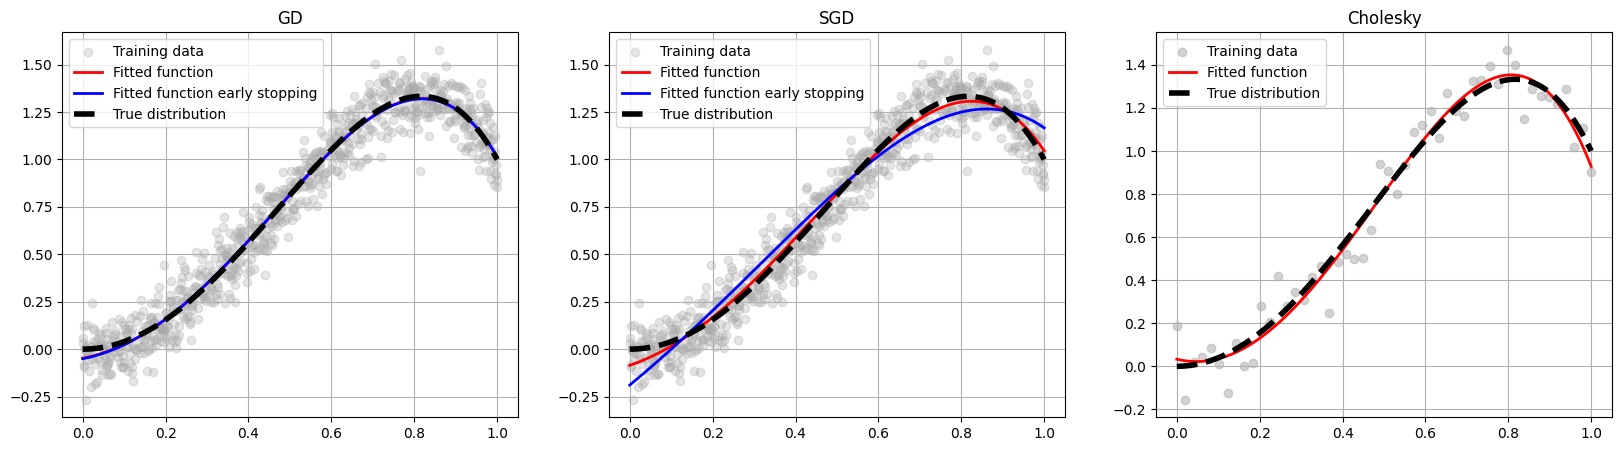

In [8]:
fig, axs = plt.subplots(figsize=(20,5), nrows=1, ncols=3)

ax = axs[0]
ax.scatter(Xtrain, Ytrain, color='darkgrey', label='Training data', alpha=0.3)  # Plot training data
X_fit = np.linspace(min(X), max(X), 200) # Create a vector of 200 points to plot
PhiX = vandermonde(X_fit,K)
ax.plot(X_fit, PhiX@theta_gd, color='red', label='Fitted function', linewidth=2)  # # Compute the polynomial function with the learned theta
ax.plot(X_fit, PhiX@theta_gd_es, color='blue', label='Fitted function early stopping', linewidth=2) # polynomial function with early stopping
ax.plot(X_fit, 4*X_fit**2 - 3*X_fit**4, color='black', label='True distribution', linewidth=4, linestyle='--') # Real polynomial function
ax.set_title('GD')
ax.legend()
ax.grid()

ax = axs[1]
ax.scatter(Xtrain, Ytrain, color='darkgrey', label='Training data', alpha=0.3)  # Plot training data
X_fit = np.linspace(min(X), max(X), 200) # Create a vector of 200 points to plot
PhiX = vandermonde(X_fit,K)
ax.plot(X_fit, PhiX@theta_sgd, color='red', label='Fitted function', linewidth=2)  # Compute the polynomial function with the learned theta
ax.plot(X_fit, PhiX@theta_sgd_es, color='blue', label='Fitted function early stopping', linewidth=2) # polynomial function with early stopping
ax.plot(X_fit, 4*X_fit**2 - 3*X_fit**4, color='black', label='True distribution', linewidth=4, linestyle='--') # Real polynomial function
ax.set_title('SGD')
ax.legend()
ax.grid()

ax = axs[2]
ax.scatter(Xsmall, Ysmall, color='darkgray', label='Training data', alpha=0.5)  # Plot training data
X_fit = np.linspace(min(Xsmall), max(Xsmall), 200) # Create a vector of 200 points to plot
PhiX = vandermonde(X_fit,K)
ax.plot(X_fit, PhiX@theta, color='red', label='Fitted function', linewidth=2)  # Compute the polynomial function with the learned theta
ax.plot(X_fit, 4*X_fit**2 - 3*X_fit**4, color='black', label='True distribution', linewidth=4, linestyle='--') # Real polynomial function
ax.set_title('Cholesky')
ax.legend()
ax.grid()



As we can see from the graph above, the convergence for GD is the same both with and without early stopping. This is not true for SGD, for which we can see a little of underfitting when early stopping is involved. Solving the problem with normal equations and $K=7$ lead to overfitting. In this case overfitting occurrs beacause $K$ is too big for the given data (small test set).

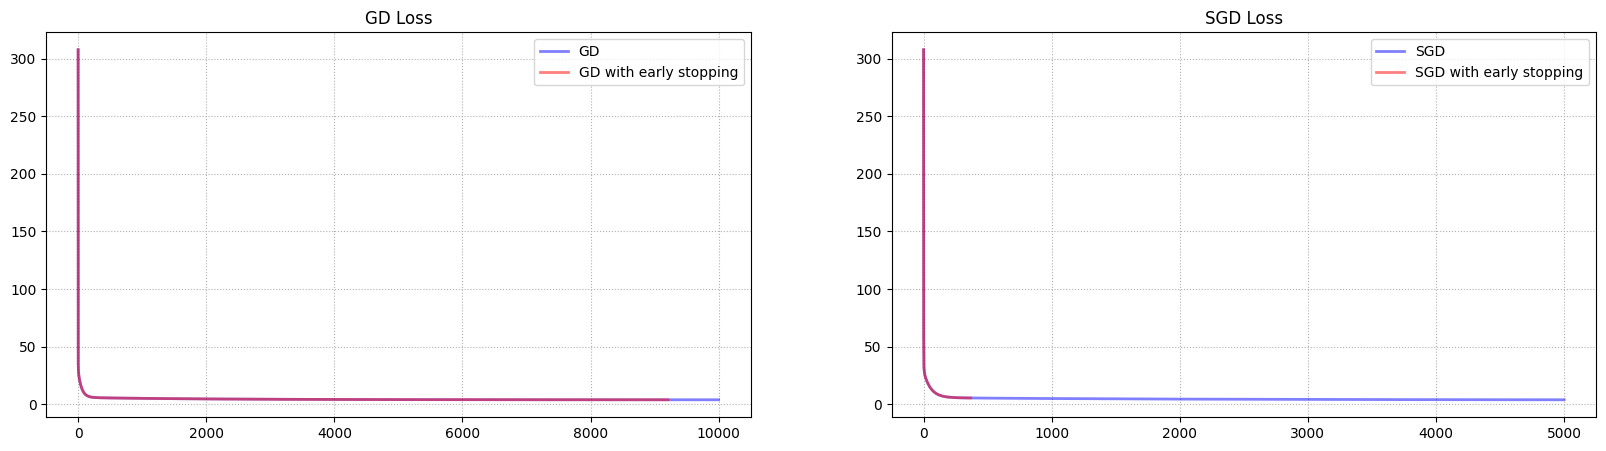

In [9]:
fig, axs = plt.subplots(figsize=(20,5), nrows=1, ncols=2)


ax = axs[0]
ax.plot(loss_gd, color='blue', label='GD', linewidth=2, alpha=0.5)
ax.plot(loss_gd_es[loss_gd_es!=0], color='red', label='GD with early stopping', linewidth=2, alpha=0.5) 
ax.set_title('GD Loss')
ax.legend()
ax.grid(linestyle=':')


ax = axs[1]

ax.plot(loss_sgd, color='blue', label='SGD', linewidth=2, alpha=0.5)
ax.plot(loss_sgd_es[loss_sgd_es!=0], color='red', label='SGD with early stopping', linewidth=2, alpha=0.5)
ax.set_title('SGD Loss')
ax.legend()
ax.grid(linestyle=':')



As we can see the loss function converges after very few epochs but theta could need more epochs to converge to the real values. This behavior occurs because loss convergence and parameter convergence are not necessarily synchronized. 

* Set $K=5$ (so that the polynomial regression model is a polynomial of degree 4). Compare the parameters learned by the three models with the true parameter $\theta^* = [0, 0, 4, 0, -3]$.

In [10]:
theta_star = np.array([0,0,4,0,-3]).reshape(-1,1)

theta_gd_norm = np.linalg.norm(theta_star-theta_gd)
theta_sgd_norm = np.linalg.norm(theta_star-theta_sgd)
theta_cho_norm = np.linalg.norm(theta_star-theta)

print(f'Theta GD \n{theta_gd} \nNorm: {theta_gd_norm} \n', end='==========\n')
print(f'Theta SGD \n{theta_sgd} \nNorm: {theta_sgd_norm} \n', end='==========\n')
print(f'Theta Normal Equations \n{theta} \nNorm: {theta_cho_norm} \n', end='==========\n')

Theta GD 
[[-0.04729327]
 [ 0.4004803 ]
 [ 3.12651286]
 [ 0.54138054]
 [-3.00876903]] 
Norm: 1.1039794795010551 
Theta SGD 
[[-0.08541906]
 [ 0.75558357]
 [ 2.58111787]
 [ 0.34626971]
 [-2.55173001]] 
Norm: 1.7065398189462222 
Theta Normal Equations 
[[ 0.03290773]
 [-0.45977277]
 [ 4.84291477]
 [ 0.1721476 ]
 [-3.66058933]] 
Norm: 1.1785551682954276 


In [11]:

PhiX_test = vandermonde(Xtest, K)
err_sgd = compute_error(Ytest, PhiX_test@theta_sgd)
err_gd = compute_error(Ytest, PhiX_test@theta_gd)
err_sgd_es = compute_error(Ytest, PhiX_test@theta_sgd_es)
err_gd_es = compute_error(Ytest, PhiX_test@theta_gd_es)
err_cho = compute_error(Ytest, PhiX_test@theta)

print(f'Test error for GD: {err_gd}')
print(f'Test error for GD with early stopping: {err_gd_es}')
print(f'Test error for SGD: {err_sgd}')
print(f'Test error for SGD with early stopping: {err_sgd_es}')
print(f'Test error for normal equations method: {err_cho}')



Test error for GD: 0.008432480001497466
Test error for GD with early stopping: 0.008441146440921594
Test error for SGD: 0.008680239612037389
Test error for SGD with early stopping: 0.011934863235804581
Test error for normal equations method: 0.00912887397950869


The error is very low also for SGD with early stopping

* Repeat the experiment by varying the degree $K$ of the polynomial. Comment the results.


Training GD for k=3


 19%|█▊        | 1871/10000 [00:00<00:00, 17480.59it/s]



Training SGD for k=3


 10%|▉         | 480/5000 [00:00<00:05, 789.51it/s]



Training GD for k=4


100%|██████████| 10000/10000 [00:00<00:00, 22773.71it/s]



Training SGD for k=4


  7%|▋         | 349/5000 [00:00<00:04, 960.33it/s]



Training GD for k=5


 92%|█████████▏| 9208/10000 [00:00<00:00, 21858.97it/s]



Training SGD for k=5


 65%|██████▍   | 3232/5000 [00:03<00:01, 939.01it/s]



Training GD for k=6


 47%|████▋     | 4706/10000 [00:00<00:00, 20797.60it/s]



Training SGD for k=6


100%|██████████| 5000/5000 [00:05<00:00, 863.09it/s]



Training GD for k=7


 30%|███       | 3046/10000 [00:00<00:00, 20063.37it/s]



Training SGD for k=7


 14%|█▍        | 723/5000 [00:00<00:04, 881.09it/s]



Training GD for k=8


 78%|███████▊  | 7828/10000 [00:00<00:00, 21745.78it/s]



Training SGD for k=8


 81%|████████▏ | 4073/5000 [00:04<00:00, 949.40it/s]



Training GD for k=10


 95%|█████████▌| 9547/10000 [00:00<00:00, 19878.16it/s]



Training SGD for k=10


 46%|████▋     | 2320/5000 [00:02<00:03, 787.63it/s]



Training GD for k=12


 72%|███████▏  | 7246/10000 [00:01<00:00, 5737.42it/s]



Training SGD for k=12


100%|██████████| 5000/5000 [00:15<00:00, 319.01it/s]


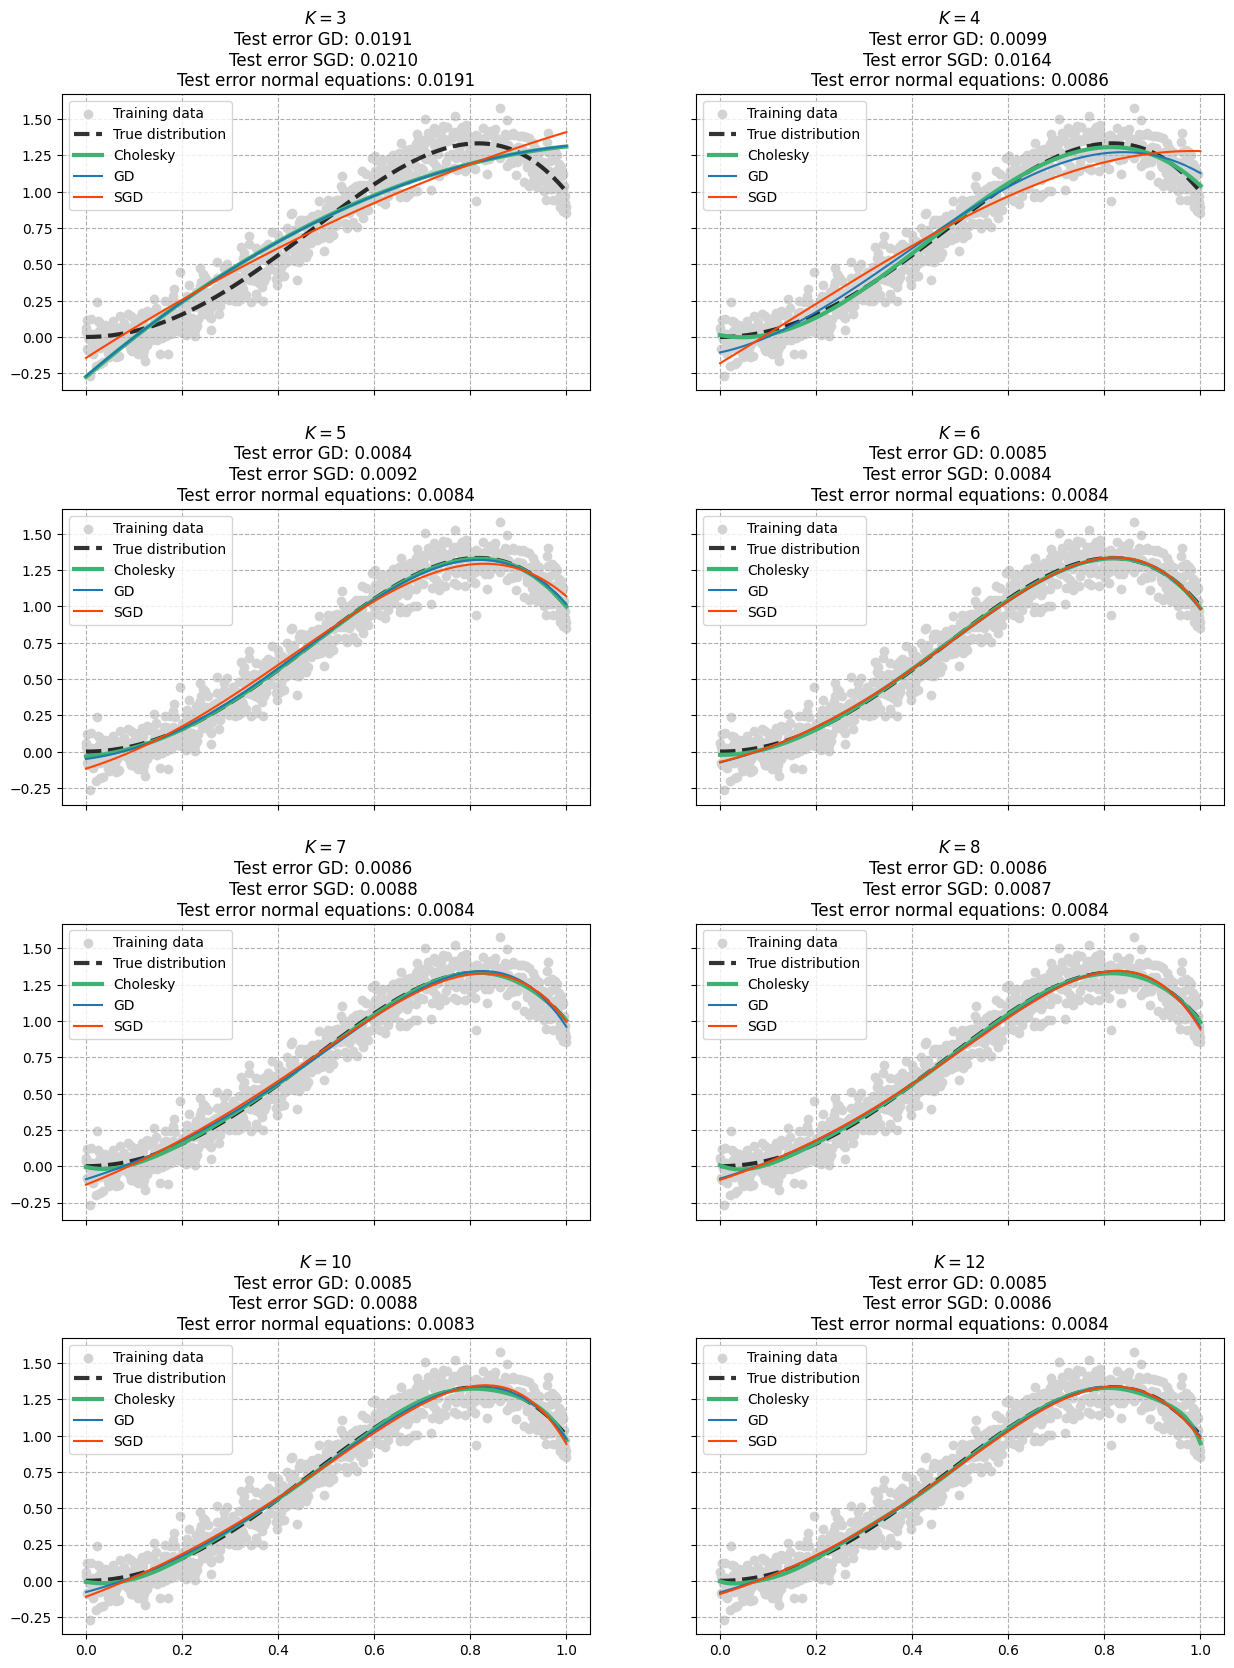

In [12]:
k_vals = np.array([3,4,5,6,7,8,10,12])
nrows = 4
ncols = 2

fig, axs = plt.subplots(figsize=(15,20), ncols=ncols, nrows=nrows, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.4)
iter = 0
for i in range(nrows):
    for j in range(ncols):

        K = k_vals[iter]

        PhiX = vandermonde(Xtrain, K) #shape (N,k)
        theta0 = np.zeros((K, 1)) #column vector

        # training gradient descent with early stopping
        print(f'\nTraining GD for k={K}')
        theta_gd_es, loss_gd_es, grad_gd_es, error_gd_es, epoch_gd_es = GD(
            loss, 
            grad_loss, 
            data=(PhiX,Ytrain), 
            epochs=10000, 
            theta0=np.zeros(K).reshape(-1,1), 
            alpha=0.001, 
            early_stopping=True
        )

        # training stochastic gradient descent with early stopping
        print(f'\nTraining SGD for k={K}')
        theta_sgd_es, loss_sgd_es, grad_sgd_es, error_sgd_es, epoch_sgd_es = SGD(
            loss, 
            grad_loss,
            batch_size=20,
            data=(PhiX,Ytrain), 
            epochs=5000, 
            theta0=np.zeros(K).reshape(-1,1), 
            alpha=0.001, 
            early_stopping=True
        )        
        theta_cholesky = cholesky(PhiX, Ytrain)

        # Compute errors on the test set
        PhiX_test = vandermonde(Xtest, K)
        err_sgd = compute_error(Ytest, PhiX_test@theta_sgd_es)
        err_gd = compute_error(Ytest, PhiX_test@theta_gd_es)
        err_cho = compute_error(Ytest, PhiX_test@theta_cholesky)

        ax = axs[i][j]
        ax.scatter(Xtrain, Ytrain, color='lightgray', label='Training data', alpha=1)
        ax.plot(X, 4*X**2 - 3*X**4, color='black', label='True distribution', linewidth=3, alpha=0.8, linestyle='--')
        ax.plot(np.linspace(0,1, 100), vandermonde(np.linspace(0,1,100), K)@theta_cholesky, color='mediumseagreen', label='Cholesky', linewidth=3)
        ax.plot(np.linspace(0,1, 100), vandermonde(np.linspace(0,1,100), K)@theta_gd_es, color='tab:blue', label='GD')
        ax.plot(np.linspace(0,1, 100), vandermonde(np.linspace(0,1,100), K)@theta_sgd_es, color='orangered', label='SGD')
        ax.set_title(f"$K = {K}$ \nTest error GD: {err_gd:.4f} \nTest error SGD: {err_sgd:.4f} \nTest error normal equations: {err_cho:.4f}")
        ax.grid(linestyle='--')
        ax.legend()

        iter += 1

For $k = 3$ all the three methods provide the same curve. The curve predicted underfits the data, meaning that it is not flexible enough to capture the complexity of the data. With $k = 4$, GD and SGD still underfitting the data while the curve predicted by Normal Equations resambles pretty well the data. The best configuration probably is for $k = 6$: all the three methods provide approximatively the same curve (maybe Normal equations method is slightely better). For higher values of $k$ (for $k \ge 8$ for example), the three methods seem to "overfit" a little bit especially Normal equations method